InChIKey14 overlaps 3 1 0


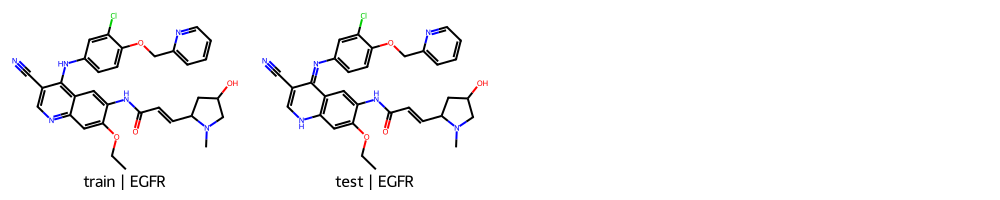

,ik14,smiles,split,proteins
15332,MGJMZWXLGRKRAN,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4ccccn4)c(Cl)c3)c2...,train,EGFR
71767,MGJMZWXLGRKRAN,CCOc1cc2[nH]cc(C#N)c(=Nc3ccc(OCc4ccccn4)c(Cl)c...,test,EGFR


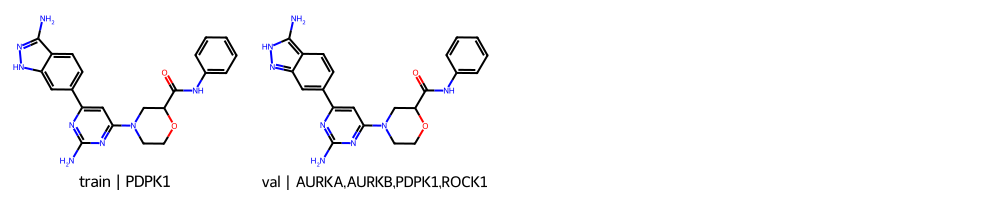

,ik14,smiles,split,proteins
45701,NCSQDKMOKNQGSG,Nc1nc(-c2ccc3c(N)n[nH]c3c2)cc(N2CCOC(C(=O)Nc3c...,train,PDPK1
63161,NCSQDKMOKNQGSG,Nc1nc(-c2ccc3c(N)[nH]nc3c2)cc(N2CCOC(C(=O)Nc3c...,val,"AURKA,AURKB,PDPK1,ROCK1"


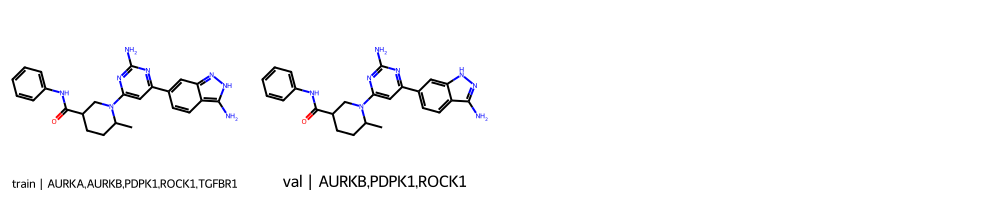

,ik14,smiles,split,proteins
3600,TXXYVBLFLGPQOR,CC1CCC(C(=O)Nc2ccccc2)CN1c1cc(-c2ccc3c(N)[nH]n...,train,"AURKA,AURKB,PDPK1,ROCK1,TGFBR1"
63186,TXXYVBLFLGPQOR,CC1CCC(C(=O)Nc2ccccc2)CN1c1cc(-c2ccc3c(N)n[nH]...,val,"AURKB,PDPK1,ROCK1"


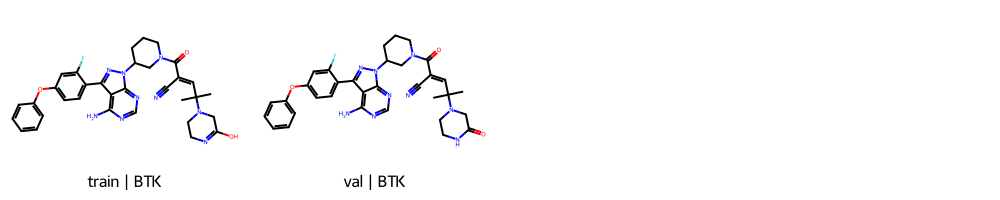

,ik14,smiles,split,proteins
8106,YIIHGHCCCVHHLX,CC(C)(C=C(C#N)C(=O)N1CCCC(n2nc(-c3ccc(Oc4ccccc...,train,BTK
63541,YIIHGHCCCVHHLX,CC(C)(C=C(C#N)C(=O)N1CCCC(n2nc(-c3ccc(Oc4ccccc...,val,BTK


comp              test            val
feature                              
HBA      3.740092e-164  6.800669e-221
HBD       4.829569e-46  2.850211e-138
LogP      3.039125e-36   1.240730e-12
MW        2.926598e-67  2.961395e-291
RB        5.867939e-07   0.000000e+00
TPSA      8.793056e-03  6.130285e-230
protein split
 ACVR2A  test
 ACVR2B   val
    BRK  test
 CAMK2A  test
  CDK11   val
    CTK train
  HIPK1  test
    LTK  test
   MEK2  test
   MEK3  test
   MLK2  test
  MYLK4  test
   NEK7 train
   NEK7   val
   NIM1 train
   PAK1  test
   PAK4  test
PIP5K1C   val
PIP5K2C  test
PIP5K2C   val
 PKMYT1   val
   PKN1  test
  RIPK5 train
 TSSK1B  test
   WNK1   val
   YSK4   val
   protein split  prev_train     prev  abs_diff            p
    ACVR2B   val    1.000000 0.000000  1.000000 3.333333e-01
      YSK4   val    1.000000 0.000000  1.000000 3.333333e-01
     RIPK5   val    0.000000 1.000000  1.000000 1.000000e+00
     CDK11   val    1.000000 0.000000  1.000000 1.666667e-01
       CTK   

In [1]:
# %%
import pandas as pd, numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem.inchi import MolToInchiKey
from scipy.stats import ks_2samp, chi2_contingency, fisher_exact

TRAIN = 'datasets/chembl_pretraining_train.csv'
VAL = 'datasets/chembl_pretraining_val.csv'
TEST = 'datasets/chembl_pretraining_test.csv'
SMILES_COL = 'smiles'
ACTIVE_THRESHOLD = 6.5
DRIFT_PCT_THRESHOLD = 0.2

# %%
def load(p, split):
    df = pd.read_csv(p)
    df['split']=split
    df['mol']=df[SMILES_COL].map(Chem.MolFromSmiles)
    df=df[df['mol'].notna()]
    return df
train=load(TRAIN,'train'); val=load(VAL,'val'); test=load(TEST,'test')
df=pd.concat([train,val,test],ignore_index=True)

# %%
df['ik14']=df['mol'].map(lambda m: MolToInchiKey(m).split('-')[0])
s={'train':set(df.query("split=='train'")['ik14']),'val':set(df.query("split=='val'")['ik14']),'test':set(df.query("split=='test'")['ik14'])}
print('InChIKey14 overlaps',len(s['train']&s['val']),len(s['train']&s['test']),len(s['val']&s['test']))
value_cols=[c for c in df.columns if c not in {SMILES_COL,'mol','split','ik14'}]
leak_keys=[k for k,n in df.groupby('ik14')['split'].nunique().items() if n>1]
leaks=df[df['ik14'].isin(leak_keys)].copy()
leaks['proteins']=leaks.apply(lambda r: ','.join(r[value_cols].dropna().index.tolist()),axis=1)
from rdkit.Chem.Draw import MolsToGridImage
from IPython.display import display
for k,sub in leaks.groupby('ik14'):
    display(MolsToGridImage(sub['mol'].tolist(),legends=(sub['split']+' | '+sub['proteins']).tolist(),molsPerRow=4,subImgSize=(250,200)))
    display(sub[['ik14',SMILES_COL,'split','proteins']]),len(s['train']&s['test']),len(s['val']&s['test'])

# %%
def feats(m):
    return pd.Series({'MW':Descriptors.MolWt(m),'LogP':Descriptors.MolLogP(m),'HBD':rdMolDescriptors.CalcNumHBD(m),'HBA':rdMolDescriptors.CalcNumHBA(m),'TPSA':rdMolDescriptors.CalcTPSA(m),'RB':rdMolDescriptors.CalcNumRotatableBonds(m)})
X=df['mol'].apply(feats)
X['split']=df['split'].values
res=[]
for f in ['MW','LogP','HBD','HBA','TPSA','RB']:
    a=X.loc[X.split=='train',f].dropna().values
    for bname in ['val','test']:
        b=X.loc[X.split==bname,f].dropna().values
        if len(a)>0 and len(b)>0:
            res.append([f,bname,ks_2samp(a,b).pvalue])
ks=pd.DataFrame(res,columns=['feature','comp','p'])
print(ks.pivot(index='feature',columns='comp',values='p').to_string())

# %%
value_cols=[c for c in df.columns if c not in {SMILES_COL,'mol','split','ik14'}]
long=df.melt(id_vars=['split'],value_vars=value_cols,var_name='protein',value_name='pchembl').dropna(subset=['pchembl'])
long['is_active']=(long['pchembl']>=ACTIVE_THRESHOLD).astype(int)

# %%
g=long.groupby(['protein','split'])['is_active'].sum().rename('actives').reset_index()
miss=g[g['actives']<1][['protein','split']]
print('Coverage PASS' if len(miss)==0 else miss.to_string(index=False))

# %%
tot=long.groupby(['protein','split'])['is_active'].agg(['sum','count']).reset_index()
comp=tot[tot['split'].isin(['val','test'])].rename(columns={'sum':'b1','count':'bn'})
base=tot[tot['split']=='train'][['protein','sum','count']].rename(columns={'sum':'a1','count':'an'})
out=comp.merge(base,on='protein',how='left').dropna(subset=['a1','an'])
out['prev_train']=out['a1']/out['an']
out['prev']=out['b1']/out['bn']
out['abs_diff']=(out['prev']-out['prev_train']).abs()
def _pv(r):
    a1=int(r['a1']); a0=int(r['an']-r['a1']); b1=int(r['b1']); b0=int(r['bn']-r['b1'])
    if 0 in (a1,a0,b1,b0):
        from scipy.stats import fisher_exact
        return fisher_exact([[a1,a0],[b1,b0]],alternative='two-sided')[1]
    return chi2_contingency([[a1,a0],[b1,b0]],correction=False)[1]
out['p']=out.apply(_pv,axis=1)
flags=out[out['abs_diff']>=DRIFT_PCT_THRESHOLD][['protein','split','prev_train','prev','abs_diff','p']].sort_values('abs_diff',ascending=False)
print('Drift PASS' if len(flags)==0 else flags.to_string(index=False))


In [14]:
# %%
import pandas as pd
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize as std
from rdkit import RDLogger
from joblib import Parallel, delayed

train_path='datasets/chembl_pretraining_train.csv'
val_path='datasets/chembl_pretraining_val.csv'
test_path='datasets/chembl_pretraining_test.csv'
smiles_col='smiles'
keep_split='train'
out_train='datasets/train_clean.csv'
out_val='datasets/val_clean.csv'
out_test='datasets/test_clean.csv'

RDLogger.DisableLog('rdApp.warning')

def load(p,split):
    d=pd.read_csv(p); d['split']=split; return d

df=pd.concat([load(train_path,'train'),load(val_path,'val'),load(test_path,'test')],ignore_index=True)

def canon_taut_smi(s):
    m=Chem.MolFromSmiles(s)
    if not m: return None
    try:
        e=std.TautomerEnumerator()
        return Chem.MolToSmiles(e.Canonicalize(m), isomericSmiles=False)
    except Exception:
        return None

df['taut']=Parallel(n_jobs=-1,prefer='processes',batch_size=1024)(delayed(canon_taut_smi)(s) for s in df[smiles_col].tolist())
df=df[df['taut'].notna()]
leak=set(df.groupby('taut')['split'].nunique().pipe(lambda s:s[s>1]).index)
mask=df['taut'].isin(leak)
removed=df[mask & (df['split']!=keep_split)][[smiles_col,'split']]
clean=df[(~mask)|(mask&(df['split']==keep_split))].drop(columns=['taut'])
clean[clean['split']=='train'].drop(columns=['split']).to_csv(out_train,index=False)
clean[clean['split']=='val'].drop(columns=['split']).to_csv(out_val,index=False)
clean[clean['split']=='test'].drop(columns=['split']).to_csv(out_test,index=False)
print(removed.to_string(index=False))


[12:52:53] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 37
[12:52:53] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 37
[12:52:53] [12:52:53] Can't kekulize mol.  Unkekulized atoms: 6 17 18 19
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 37
[12:52:53] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 37
[12:52:53] Can't kekulize mol.  Unkekulized atoms: 4 15 16 17
[12:52:53] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 37
[12:52:53] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 37
[12:52:53] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 37
[12:52:53] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 37
[12:52:53] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 37
[12:52:54] Tautomer enumeration stopped at 144 tautomers: max transforms reached
[12:52:54] Tautomer enumeration stopped at 177 tautomers: max transforms reached
[12:52:54] Tautomer enumeration stopped at 401 tautomers: max transforms reached
[12:52:54] T

                                                                           smiles split
                        Nc1nc(-c2ccc3c(N)[nH]nc3c2)cc(N2CCOC(C(=O)Nc3ccccc3)C2)n1   val
                       CC1CCC(C(=O)Nc2ccccc2)CN1c1cc(-c2ccc3c(N)n[nH]c3c2)nc(N)n1   val
CC(C)(C=C(C#N)C(=O)N1CCCC(n2nc(-c3ccc(Oc4ccccc4)cc3F)c3c(N)ncnc32)C1)N1CCNC(=O)C1   val
                            COc1cc(O)c2c(c1)-c1cccc(c1)C(O)C(O)C(=O)C=CCC(C)OC2=O   val
                                COCC1OC(=O)c2coc3c2C1(C)C1=CCC2(C)C(=O)CCC2C1C3=O   val
                                   O=C1c2[nH]c3cc(-c4ccco4)nn3c(=O)c2CN1Cc1ccccc1  test
        CCOc1cc2[nH]cc(C#N)c(=Nc3ccc(OCc4ccccn4)c(Cl)c3)c2cc1NC(=O)C=CC1CC(O)CN1C  test


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Scaffolds import MurckoScaffold
from scipy.stats import ks_2samp
from collections import defaultdict
from multiprocessing import Pool, cpu_count
import functools

def get_scaffold(smi):
   mol = Chem.MolFromSmiles(smi)
   if mol is not None:
       scaffold = MurckoScaffold.GetScaffoldForMol(mol)
       if scaffold is not None:
           return Chem.MolToSmiles(scaffold, isomericSmiles=False)
   return None

def get_fingerprint(smi):
   fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
   mol = Chem.MolFromSmiles(smi)
   if mol is not None:
       fp = fpgen.GetFingerprint(mol)
       return np.array(fp)
   return np.zeros(2048)

def compute_max_similarity(args):
   query_fp, train_fps = args
   max_sim = 0
   for train_fp in train_fps:
       intersection = np.sum(query_fp & train_fp)
       union = np.sum(query_fp | train_fp)
       sim = intersection / union if union > 0 else 0
       max_sim = max(max_sim, sim)
   return max_sim

def validate_split_integrity():
   # Load datasets
   print("Loading datasets...")
   train = pd.read_csv('datasets/chembl_pretraining_train.csv')
   val = pd.read_csv('datasets/chembl_pretraining_val.csv')
   test = pd.read_csv('datasets/chembl_pretraining_test.csv')
   
   datasets = {'train': train, 'val': val, 'test': test}
   all_smiles = {}
   
   print("1. Computing scaffolds and checking for violations...")
   scaffold_to_split = {}
   scaffold_violations = []
   
   n_cores = cpu_count()
   
   for split_name, df in datasets.items():
       all_smiles[split_name] = df['smiles'].tolist()
       print(f"  Processing {split_name}: {len(df)} compounds")
       
       with Pool(n_cores) as pool:
           scaffolds = pool.map(get_scaffold, df['smiles'])
       
       for smi, scaffold_smi in zip(df['smiles'], scaffolds):
           if scaffold_smi is not None:
               if scaffold_smi in scaffold_to_split:
                   if scaffold_to_split[scaffold_smi] != split_name:
                       scaffold_violations.append((scaffold_smi, scaffold_to_split[scaffold_smi], split_name))
               else:
                   scaffold_to_split[scaffold_smi] = split_name
   
   print(f"  Found {len(scaffold_violations)} scaffold violations")
   
   print("2. Computing molecular fingerprints...")
   train_fps, val_fps, test_fps = [], [], []
   
   for split_name, smiles_list in all_smiles.items():
       print(f"  Computing fingerprints for {split_name}...")
       with Pool(n_cores) as pool:
           fps = pool.map(get_fingerprint, smiles_list)
       
       if split_name == 'train':
           train_fps = np.array(fps)
       elif split_name == 'val':
           val_fps = np.array(fps)
       else:
           test_fps = np.array(fps)
   
   print("3. Analyzing molecular similarities...")
   high_similarity_violations = []
   
   for split_name, query_fps in [('val', val_fps), ('test', test_fps)]:
       print(f"  Checking {split_name} vs train similarities...")
       
       with Pool(n_cores) as pool:
           args = [(query_fp, train_fps) for query_fp in query_fps]
           max_sims = pool.map(compute_max_similarity, args)
       
       for i, max_sim in enumerate(max_sims):
           if max_sim > 0.8:
               high_similarity_violations.append((split_name, i, max_sim))
   
   print(f"  Found {len(high_similarity_violations)} high similarity violations (>0.8)")
   
   print("4. Validating protein activity coverage...")
   protein_cols = [col for col in train.columns if col != 'smiles']
   coverage_matrix = {}
   missing_coverage = []
   
   for protein in protein_cols:
       coverage_matrix[protein] = {}
       for split_name, df in datasets.items():
           active_count = df[protein].notna().sum()
           coverage_matrix[protein][split_name] = active_count
           if active_count == 0:
               missing_coverage.append((protein, split_name))
   
   print(f"  Found {len(missing_coverage)} proteins missing from splits")
   
   print("5. Analyzing statistical distributions...")
   distribution_violations = []
   
   for i, protein in enumerate(protein_cols):
       if i % 50 == 0:
           print(f"  Processing protein {i+1}/{len(protein_cols)}")
       
       train_values = train[protein].dropna()
       val_values = val[protein].dropna()
       test_values = test[protein].dropna()
       
       if len(train_values) > 10 and len(val_values) > 10:
           stat, p_val = ks_2samp(train_values, val_values)
           if p_val < 0.001:
               distribution_violations.append((protein, 'train_val', p_val))
       
       if len(train_values) > 10 and len(test_values) > 10:
           stat, p_val = ks_2samp(train_values, test_values)
           if p_val < 0.001:
               distribution_violations.append((protein, 'train_test', p_val))
   
   print(f"  Found {len(distribution_violations)} distribution violations (p<0.001)")
   
   return {
       'scaffold_violations': scaffold_violations,
       'high_similarity_violations': high_similarity_violations,
       'missing_coverage': missing_coverage,
       'distribution_violations': distribution_violations,
       'total_scaffolds': len(scaffold_to_split),
       'coverage_matrix': coverage_matrix
   }

print("Starting data leakage validation...")
results = validate_split_integrity()

print("\n=== VALIDATION RESULTS ===")
print(f"Scaffold violations: {len(results['scaffold_violations'])}")
print(f"High similarity violations (>0.8): {len(results['high_similarity_violations'])}")
print(f"Proteins missing from splits: {len(results['missing_coverage'])}")
print(f"Distribution violations (p<0.001): {len(results['distribution_violations'])}")
print(f"Total unique scaffolds: {results['total_scaffolds']}")
         

Starting data leakage validation...
Loading datasets...
1. Computing scaffolds and checking for violations...
  Processing train: 62550 compounds
  Processing val: 6693 compounds
  Processing test: 10238 compounds
  Found 0 scaffold violations
2. Computing molecular fingerprints...
  Computing fingerprints for train...
  Computing fingerprints for val...
  Computing fingerprints for test...
3. Analyzing molecular similarities...
  Checking val vs train similarities...
  Checking test vs train similarities...
  Found 1484 high similarity violations (>0.8)
4. Validating protein activity coverage...
  Found 125 proteins missing from splits
5. Analyzing statistical distributions...
  Processing protein 1/357
  Processing protein 51/357
  Processing protein 101/357
  Processing protein 151/357
  Processing protein 201/357
  Processing protein 251/357
  Processing protein 301/357
  Processing protein 351/357
  Found 99 distribution violations (p<0.001)

=== VALIDATION RESULTS ===
Scaffold vi